## Setup

In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
os.chdir('..')
import virl

from IPython import display

In [2]:
from q_learning_nn.nn_function_approximator import NNFunctionApproximatorJointKeras, init_networks, load_trained_network
from q_learning_nn.memory import ReplayMemory, Transition
from q_learning_nn.agent import Agent
from q_learning_nn.strategy import Strategy
from q_learning_nn.run import qlearning_nn

# Training

Episode = 94. Num Exploits = 3. Total Reward = -0.962376427401035. Moving Average Reward = nan


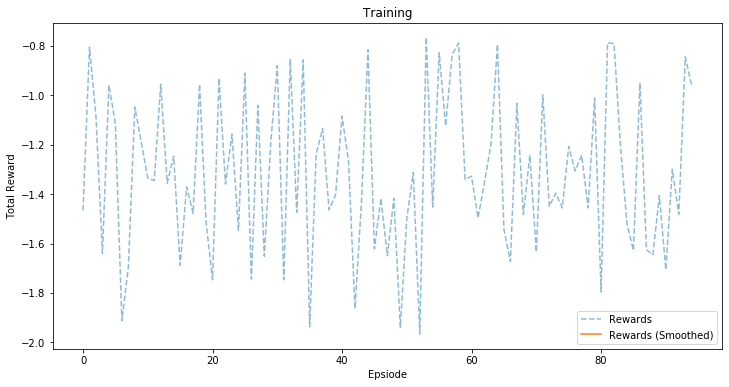

In [ ]:
episodes = 2000
epsilon_decay = 0.999985
window_size = 100

env = virl.Epidemic(stochastic=False, noisy=False, problem_id=4)
agent = Agent(env, learning_rate=0.002)
memory = ReplayMemory(size=2080, batch_size=208)  # only actually gets the best 104 samples from 208

strategy = Strategy(epsilon=1, epsilon_decay=epsilon_decay)
policy_network, target_network = init_networks(agent.get_num_states(), agent.get_num_actions(), agent.learning_rate)

rewards = qlearning_nn(
    agent=agent, 
    policy_network=policy_network, 
    target_network=target_network,
    num_episodes=episodes,
    window_size=window_size, 
    strategy=strategy,
    memory=memory
)

# Save Trained Network

In [ ]:
# policy_network.model.save_weights("policy_network_problem_id_XX.h5")